<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode009.cluster


In [2]:
!nvidia-smi

Wed Apr 12 22:27:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   37C    P0   138W / 300W |  35096MiB / 81920MiB |     98%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
CPU times: user 2min 5s, sys: 41 ms, total: 2min 5s
Wall time: 2min 6s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{45}$ and $q_{55}$')

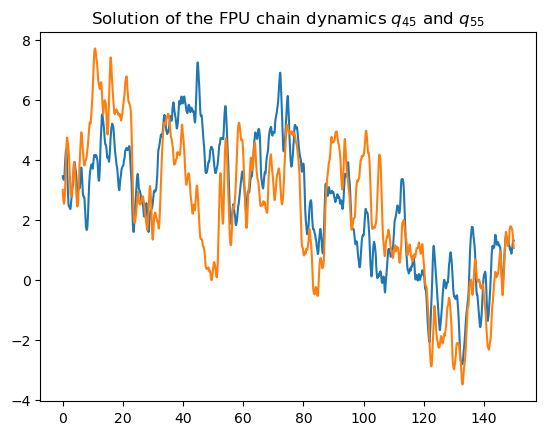

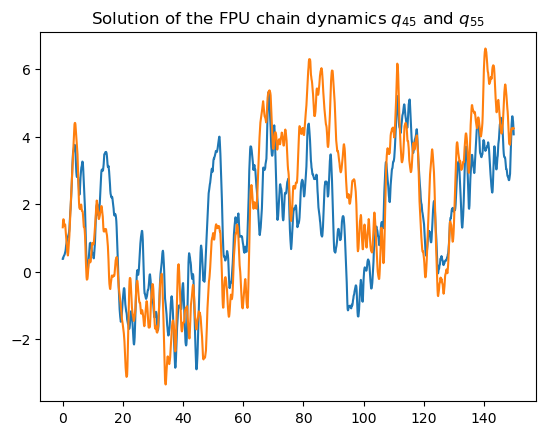

In [7]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.1
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q45,q55)
q45_store = np.zeros([t_store.size+1,batch])    
q55_store = np.zeros([t_store.size+1,batch])



q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q45_store[j,:]= np.sum(q1[0:45,:], axis=0)
        q55_store[j,:]= np.sum(q1[0:55,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q45_store=q45_store[Toss:-1,:] 
q55_store=q55_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q45_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q55_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{45}$ and $q_{55}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q45_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q55_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{45}$ and $q_{55}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


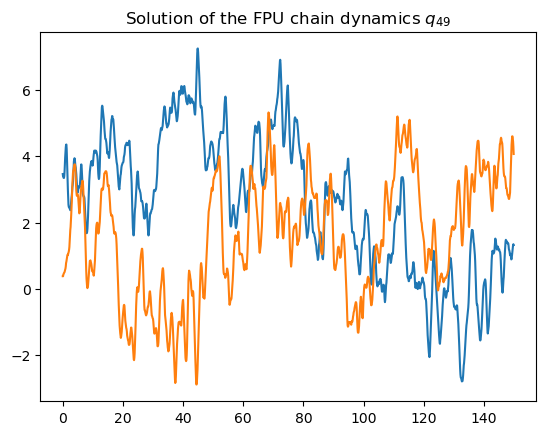

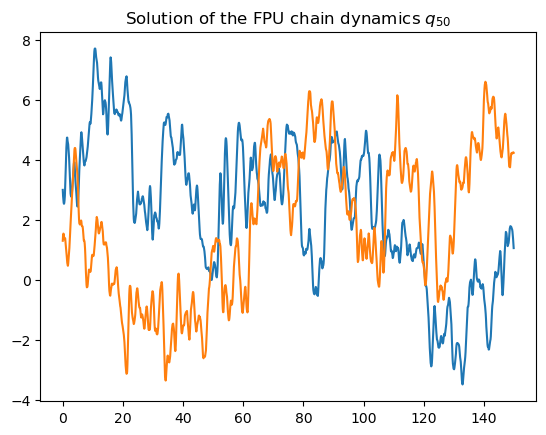

In [8]:
plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q45_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{49}$")

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q55_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{50}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj45 = q45_store[0:sec_length,:]
Traj55 = q55_store[0:sec_length,:]
print(ini.shape, Traj45.shape, Traj55.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj45
Traj[:,:,1] = Traj55
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [10]:
# Defining Loss functions
LAGS = sec_length
N = sec_length
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

torch.Size([400, 2])


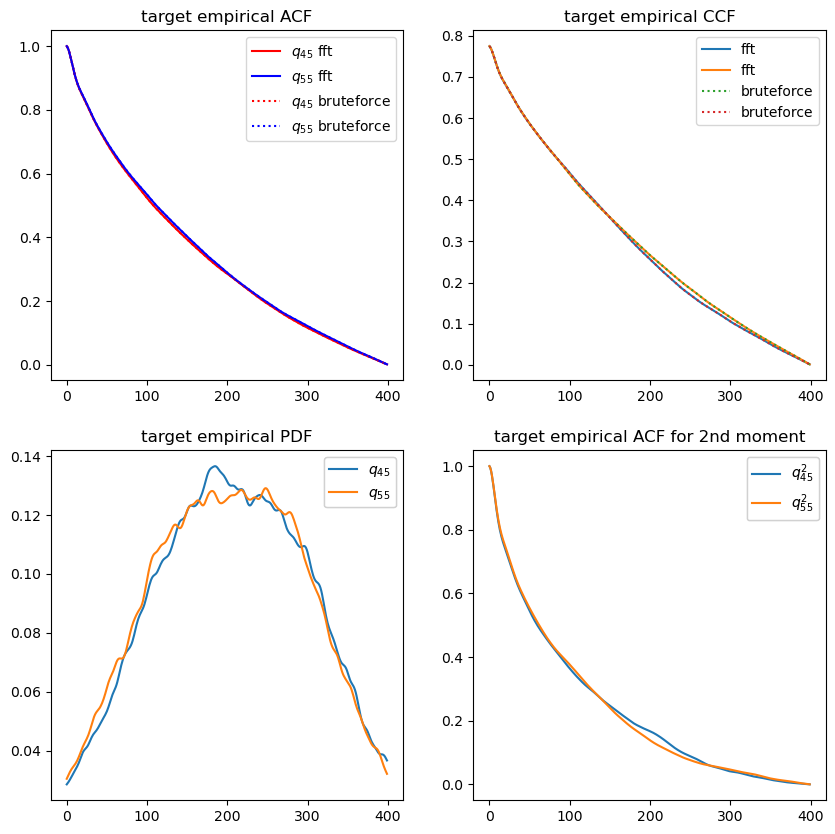

In [11]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{45}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{55}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{45}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{55}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{45}$',r'$q_{55}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{45}^2$',r'$q_{55}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

In [12]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [13]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.580, 0.579
[50]-th step loss: 0.542, 0.543
[100]-th step loss: 0.343, 0.332
[150]-th step loss: 0.110, 0.123
[200]-th step loss: 0.096, 0.083
[250]-th step loss: 0.070, 0.071
[300]-th step loss: 0.068, 0.067
[350]-th step loss: 0.069, 0.077
[400]-th step loss: 0.105, 0.092
[450]-th step loss: 0.067, 0.069
[500]-th step loss: 0.061, 0.061
[550]-th step loss: 0.058, 0.055
[600]-th step loss: 0.060, 0.058
[650]-th step loss: 0.203, 0.247
[700]-th step loss: 0.150, 0.141
[750]-th step loss: 0.123, 0.110
[800]-th step loss: 0.094, 0.081
[850]-th step loss: 0.047, 0.042
[900]-th step loss: 0.039, 0.040
[950]-th step loss: 0.041, 0.036
[1000]-th step loss: 0.038, 0.036
[1050]-th step loss: 0.038, 0.038
[1100]-th step loss: 0.035, 0.032
[1150]-th step loss: 0.032, 0.030
[1200]-th step loss: 0.096, 0.085
[1250]-th step loss: 0.040, 0.036
[1300]-th step loss: 0.030, 0.029
[1350]-th step loss: 0.045, 0.046
[1400]-th step loss: 0.027, 0.024
[1450]-th step loss: 0.027, 0.025
[15

[12050]-th step loss: 0.018, 0.017
[12100]-th step loss: 0.017, 0.017
[12150]-th step loss: 0.017, 0.017
[12200]-th step loss: 0.017, 0.017
[12250]-th step loss: 0.018, 0.017
[12300]-th step loss: 0.020, 0.018
[12350]-th step loss: 0.017, 0.017
[12400]-th step loss: 0.019, 0.017
[12450]-th step loss: 0.018, 0.017
[12500]-th step loss: 0.017, 0.017
[12550]-th step loss: 0.018, 0.017
[12600]-th step loss: 0.017, 0.017
[12650]-th step loss: 0.017, 0.017
[12700]-th step loss: 0.017, 0.017
[12750]-th step loss: 0.017, 0.017
[12800]-th step loss: 0.019, 0.017
[12850]-th step loss: 0.017, 0.017
[12900]-th step loss: 0.017, 0.017
[12950]-th step loss: 0.017, 0.017
[13000]-th step loss: 0.018, 0.017
[13050]-th step loss: 0.017, 0.017
[13100]-th step loss: 0.018, 0.017
[13150]-th step loss: 0.018, 0.017
[13200]-th step loss: 0.017, 0.017
[13250]-th step loss: 0.017, 0.017
[13300]-th step loss: 0.019, 0.017
[13350]-th step loss: 0.017, 0.017
[13400]-th step loss: 0.017, 0.019
[13450]-th step loss

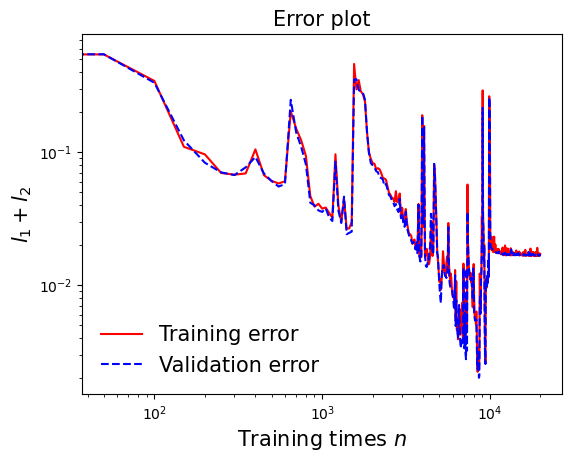

In [15]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/CG_training_error.pdf", dpi=150)

In [16]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14e09d618fa0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

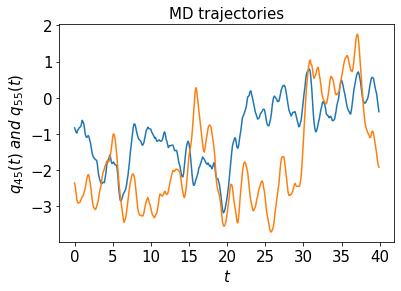

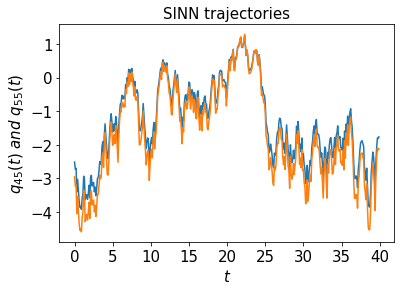

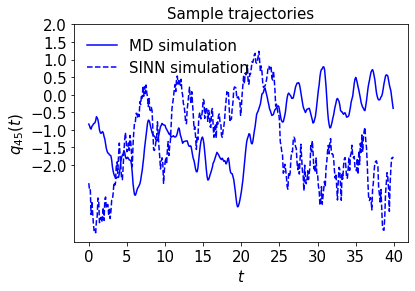

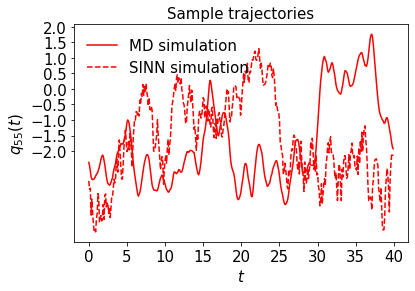

In [17]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q_{45}(t)\ and\ q_{55}(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q_{45}(t)\ and\ q_{55}(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 0],'b', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q_{45}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q_{55}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

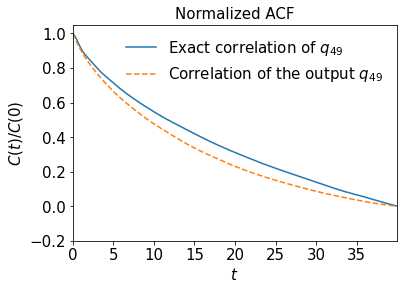

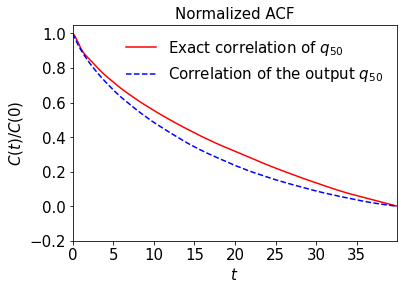

In [18]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.detach().cpu().numpy()
corr_t=acf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,0],'',label=r'Exact correlation of $q_{49}$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], '--',label=r'Correlation of the output $q_{49}$')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $q_{50}$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output $q_{50}$')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

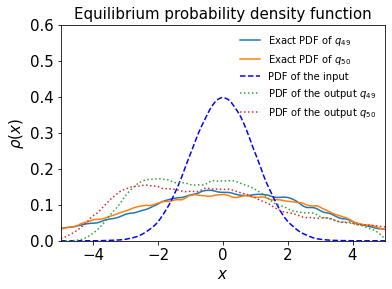

In [19]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{49}$')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{50}$')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{49}$')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{50}$')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

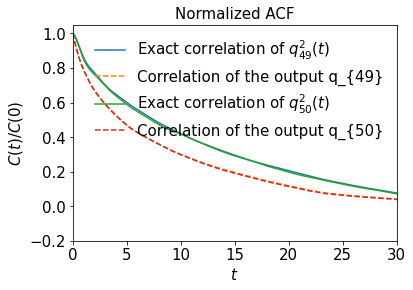

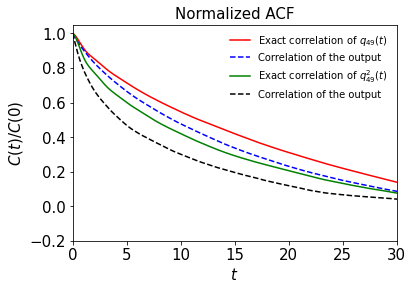

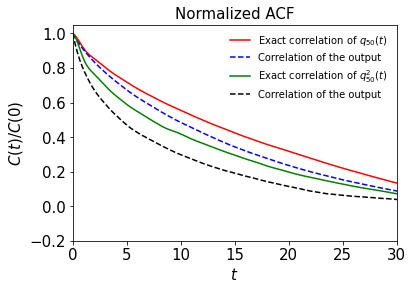

In [20]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],label=r'Exact correlation of $q_{49}^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q_{49}')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],label=r'Exact correlation of $q_{50}^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output q_{50}')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t[...,0],'r',label=r'Exact correlation of $q_{49}(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], 'b--',label=r'Correlation of the output')   
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'g',label=r'Exact correlation of $q_{49}^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=10)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $q_{50}(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output')   
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'g',label=r'Exact correlation of $q_{50}^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

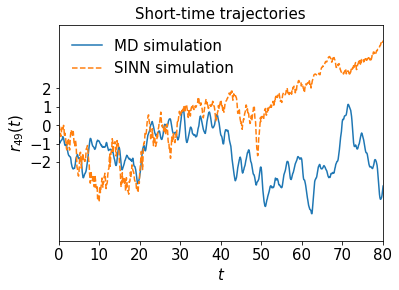

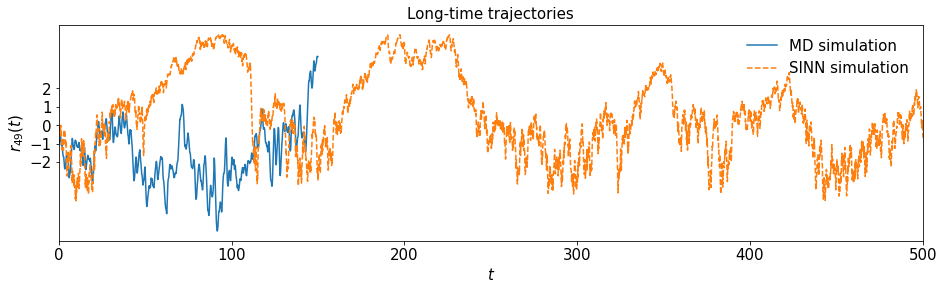

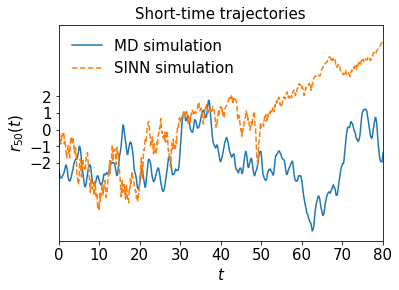

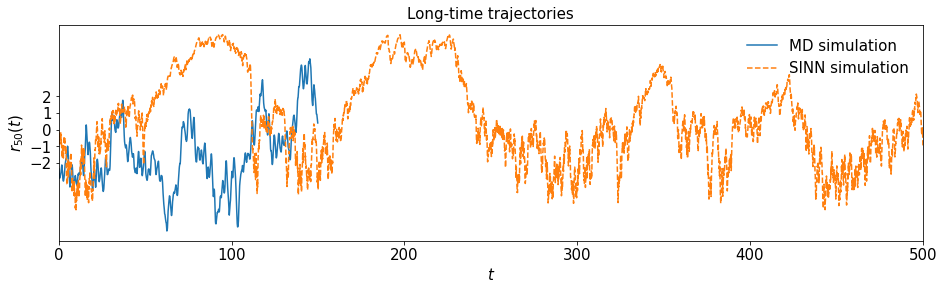

In [21]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q45_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0,0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r_{49}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q45_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0,0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r_{49}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q55_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0,1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r_{50}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q55_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0,1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r_{50}(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)